<a href="https://colab.research.google.com/github/marinathomas/SentimentAnalysisHN/blob/master/files/HN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.cloud import bigquery
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
credential_path = "/content/gdrive/Shared drives/HackerNews:SentimentAnalysis/hackernews-v2-14382f16e9b5.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

1. Load the BigQuery client
2. Get a reference to HackerNews dataset
3. Load the data set

In [0]:
client = bigquery.Client()
hn_dataset_ref = client.dataset('hacker_news', project='bigquery-public-data')
hn_dset = client.get_dataset(hn_dataset_ref)

List all the tables

In [4]:
[x.table_id for x in client.list_tables(hn_dset)]

['comments', 'full', 'full_201510', 'stories']

Take a closer look at table full

In [6]:
hn_full = client.get_table(hn_dset.table('full'))
hn_full.schema

[SchemaField('title', 'STRING', 'NULLABLE', 'Story title', ()),
 SchemaField('url', 'STRING', 'NULLABLE', 'Story url', ()),
 SchemaField('text', 'STRING', 'NULLABLE', 'Story or comment text', ()),
 SchemaField('dead', 'BOOLEAN', 'NULLABLE', 'Is dead?', ()),
 SchemaField('by', 'STRING', 'NULLABLE', "The username of the item's author.", ()),
 SchemaField('score', 'INTEGER', 'NULLABLE', 'Story score', ()),
 SchemaField('time', 'INTEGER', 'NULLABLE', 'Unix time', ()),
 SchemaField('timestamp', 'TIMESTAMP', 'NULLABLE', 'Timestamp for the unix time', ()),
 SchemaField('type', 'STRING', 'NULLABLE', 'Type of details (comment, comment_ranking, poll, story, job, pollopt)', ()),
 SchemaField('id', 'INTEGER', 'NULLABLE', "The item's unique id.", ()),
 SchemaField('parent', 'INTEGER', 'NULLABLE', 'Parent comment ID', ()),
 SchemaField('descendants', 'INTEGER', 'NULLABLE', 'Number of story or poll descendants', ()),
 SchemaField('ranking', 'INTEGER', 'NULLABLE', 'Comment ranking', ()),
 SchemaField(

I am interested to know what is in the 'type' column

In [7]:
query = """
SELECT distinct(type) FROM `bigquery-public-data.hacker_news.full`
"""

query_job = client.query(query)
rows = query_job.result(timeout=30)
for row in rows:
  print(row.type)

comment
story
job
pollopt
poll


Lets take a look at 'comments' table

In [8]:
hn_comments = client.get_table(hn_dset.table('comments'))
hn_comments.schema

[SchemaField('id', 'INTEGER', 'NULLABLE', 'Unique comment ID', ()),
 SchemaField('by', 'STRING', 'NULLABLE', 'Username of commenter', ()),
 SchemaField('author', 'STRING', 'NULLABLE', 'Username of author', ()),
 SchemaField('time', 'INTEGER', 'NULLABLE', 'Unix time', ()),
 SchemaField('time_ts', 'TIMESTAMP', 'NULLABLE', 'Human readable time in UTC (format: YYYY-MM-DD hh:mm:ss)', ()),
 SchemaField('text', 'STRING', 'NULLABLE', 'Comment text', ()),
 SchemaField('parent', 'INTEGER', 'NULLABLE', 'Parent comment ID', ()),
 SchemaField('deleted', 'BOOLEAN', 'NULLABLE', 'Is deleted?', ()),
 SchemaField('dead', 'BOOLEAN', 'NULLABLE', 'Is dead?', ()),
 SchemaField('ranking', 'INTEGER', 'NULLABLE', 'Comment ranking', ())]

Check the data

In [10]:
query = """
SELECT *
FROM `bigquery-public-data.hacker_news.comments`  order by time desc
LIMIT 20
"""

query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

comments = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
comments.fillna(0, inplace=True)
comments.head(5)

,id,by,author,time,time_ts,text,parent,deleted,dead,ranking
0,10379195,rhaps0dy,rhaps0dy,1444725842,2015-10-13 08:44:02+00:00,I&#x27;m not sure how much of it has been prov...,10379167,0,0,0
1,10379193,pixelHD,pixelHD,1444725804,2015-10-13 08:43:24+00:00,Minecraft eh? I did the same with GTA San Andr...,10377203,0,0,0
2,10379192,test1235,test1235,1444725705,2015-10-13 08:41:45+00:00,I think the closest universal interest for me ...,10372063,0,0,0
3,10379190,copsarebastards,copsarebastards,1444725645,2015-10-13 08:40:45+00:00,&gt; Why do you care about the success of the ...,10376640,0,0,0
4,10379189,spike021,spike021,1444725623,2015-10-13 08:40:23+00:00,What kinds of ramifications would there be if ...,10378759,0,0,1


This table does not have entries after 2015

Lets take a look at stories table

In [11]:
hn_stories = client.get_table(hn_dset.table('stories'))
hn_stories.schema

[SchemaField('id', 'INTEGER', 'NULLABLE', 'Unique story ID', ()),
 SchemaField('by', 'STRING', 'NULLABLE', 'Username of submitter', ()),
 SchemaField('score', 'INTEGER', 'NULLABLE', 'Story score', ()),
 SchemaField('time', 'INTEGER', 'NULLABLE', 'Unix time', ()),
 SchemaField('time_ts', 'TIMESTAMP', 'NULLABLE', 'Human readable time in UTC (format: YYYY-MM-DD hh:mm:ss)', ()),
 SchemaField('title', 'STRING', 'NULLABLE', 'Story title', ()),
 SchemaField('url', 'STRING', 'NULLABLE', 'Story url', ()),
 SchemaField('text', 'STRING', 'NULLABLE', 'Story text', ()),
 SchemaField('deleted', 'BOOLEAN', 'NULLABLE', 'Is deleted?', ()),
 SchemaField('dead', 'BOOLEAN', 'NULLABLE', 'Is dead?', ()),
 SchemaField('descendants', 'INTEGER', 'NULLABLE', 'Number of story descendants', ()),
 SchemaField('author', 'STRING', 'NULLABLE', 'Username of author', ())]

In [0]:
Lets check count of stories

In [13]:
query = """
select * except (time)
from `bigquery-public-data.hacker_news.stories` 
where REGEXP_CONTAINS(title, r"(S|s)how HN") 
order by time desc limit 5;

"""

query_job = client.query(query)

iterator = query_job.result(timeout=30)
rows = list(iterator)

stories = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

stories.head()

,id,by,score,time_ts,title,url,text,deleted,dead,descendants,author
0,10378910,achillean,3,2015-10-13 06:53:28+00:00,Show HN: Interactive Maps for IoT Search Engin...,https://maps.shodan.io/#36.421282443649496/-99...,None,None,None,0,achillean
1,10378770,LightMachine,11,2015-10-13 06:05:14+00:00,Show HN: LJSON: JSON extended with pure functions,https://github.com/MaiaVictor/LJSON,None,None,None,2,LightMachine
2,10378710,abhi1304,2,2015-10-13 05:36:31+00:00,Show HN: AI/NLP based Grammar App for students...,http://nounshoun.com,None,None,None,0,abhi1304
3,10378502,mbeg,2,2015-10-13 04:07:36+00:00,Show HN: VirtuBroker – Sell your home with a v...,http://www.virtubroker.com/,None,None,None,1,mbeg
4,10378240,kiboapp,2,2015-10-13 02:34:22+00:00,Show HN: iOS App Lets You Hide Messages in You...,http://techcrunch.com/2015/10/10/kibo-ios-app-...,None,None,None,0,kiboapp


The stories table also has data only until 2015

In [16]:
query = """
select * except (time)
from `bigquery-public-data.hacker_news.full` 
where type = 'comment'
order by time desc limit 3
"""

query_job = client.query(query)

iterator = query_job.result(timeout=30)
rows = list(iterator)

headlines = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

headlines.head(3)

,title,url,text,dead,by,score,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,"That&#x27;s correct. Moreover, it&#x27;s only ...",None,littlestymaar,None,2019-12-08 09:58:24+00:00,comment,21735153,21735081,None,None,None
1,None,None,"I created Pion WebRTC so I am biased, but thes...",None,Sean-Der,None,2019-12-08 09:58:14+00:00,comment,21735152,21731518,None,None,None
2,None,None,"Reshared: <a href=""https:&#x2F;&#x2F;news.ycom...",None,gitrebase,None,2019-12-08 09:57:23+00:00,comment,21735151,21734690,None,None,None


In [44]:
query = """
select * except (time)
from `bigquery-public-data.hacker_news.full` 
where REGEXP_CONTAINS(title, r"(S|s)how HN")
order by time desc --limit 3
"""

query_job = client.query(query)

iterator = query_job.result(timeout=30)
rows = list(iterator)

headlines = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

headlines.head(3)

,title,url,text,dead,by,score,timestamp,type,id,parent,descendants,ranking,deleted
0,Show HN: Concurrently Download and Arrange the...,https://github.com/rootVIII/go101doc,None,None,rootVIII,2,2019-12-08 07:25:47+00:00,story,21734753,None,0.0,None,None
1,Show HN: Unofficial .NET SDK for the Anki Vect...,https://github.com/codaris/Anki.Vector.SDK,None,None,wvenable,4,2019-12-08 05:11:23+00:00,story,21734437,None,2.0,None,None
2,"Show HN: Work-in-Process, HR-AV Open-Source An...",https://github.com/zelon88/HR-AV,None,None,zelon88,2,2019-12-08 04:33:03+00:00,story,21734350,None,0.0,None,None


The full table seems to have the most recent stories and comments

Its determined to use the table 'full' to get comments and the story details


Get total number of comments from the table 

In [0]:
query = """
select count(id) as total_comments
from `bigquery-public-data.hacker_news.full` 
where type = 'comment' and  
parent in (select id from `bigquery-public-data.hacker_news.full` where REGEXP_CONTAINS(title, r"(S|s)how HN"));
"""
query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)
count = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

print(count)
#print("Total number of comments {}".format(count.total_comments.values[0]))


   total_comments
0          175711


There are 175711 comments that we need to analyze

In [0]:
query = """
select  *
from `bigquery-public-data.hacker_news.full` 
where type = 'comment' and  
parent in (select id from `bigquery-public-data.hacker_news.full` where REGEXP_CONTAINS(title, r"(S|s)how HN"))
order by parent;
"""
query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
comments = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
#comments.head()

In [20]:
comments.shape

(181391, 14)

In [22]:
comments.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,I have a few comments for you guys about our d...,None,lbrandy,None,1236709075,2009-03-10 18:17:55+00:00,comment,510321,510264,None,None,None
1,None,None,This is amazing... although it needs some addi...,None,thepanister,None,1236729900,2009-03-11 00:05:00+00:00,comment,510977,510264,None,None,None
2,None,None,My first R&#38;D project at my company when I ...,None,spydez,None,1236707807,2009-03-10 17:56:47+00:00,comment,510296,510264,None,None,None
3,None,None,"<i>Sorry, we are experiencing a large volume o...",None,dkokelley,None,1236709329,2009-03-10 18:22:09+00:00,comment,510328,510264,None,None,None
4,None,None,"Seems to work, good job.",None,vaksel,None,1236711305,2009-03-10 18:55:05+00:00,comment,510385,510264,None,None,None


In [0]:
There are 181391 top level comments to analyse. May be we should restrict this analysis to one specific year

In [36]:
print(pd.DatetimeIndex(comments['timestamp']).year)

Int64Index([2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
           dtype='int64', name='timestamp', length=181391)


In [0]:
comments['Year'] = pd.DatetimeIndex(comments['timestamp']).year

In [39]:
comments.head(3)

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted,Year
0,None,None,I have a few comments for you guys about our d...,None,lbrandy,None,1236709075,2009-03-10 18:17:55+00:00,comment,510321,510264,None,None,None,2009
1,None,None,This is amazing... although it needs some addi...,None,thepanister,None,1236729900,2009-03-11 00:05:00+00:00,comment,510977,510264,None,None,None,2009
2,None,None,My first R&#38;D project at my company when I ...,None,spydez,None,1236707807,2009-03-10 17:56:47+00:00,comment,510296,510264,None,None,None,2009


In [42]:
comments.groupby('Year').count()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
Year,,,,,,,,,,,,,,
2009,0,0,26,1,26,0,26,26,26,26,26,0,0,0
2010,0,0,1632,17,1632,0,1666,1666,1666,1666,1666,0,0,34
2011,0,0,11169,236,11169,0,11461,11461,11461,11461,11461,0,0,292
2012,0,0,19185,444,19185,0,19650,19650,19650,19650,19650,0,0,465
2013,0,0,20894,486,20895,0,21419,21419,21419,21419,21419,0,0,524
2014,0,0,23175,397,23177,0,23783,23783,23783,23783,23783,0,0,606
2015,0,0,20569,443,20571,0,21077,21077,21077,21077,21077,0,0,506
2016,0,0,19422,498,19423,0,20016,20016,20016,20016,20016,0,0,593
2017,0,0,20572,466,20574,0,21142,21142,21142,21142,21142,0,0,568


In [45]:
headlines.shape

(82665, 13)

In [0]:
headlines['Year'] = pd.DatetimeIndex(headlines['timestamp']).year

In [47]:
headlines.groupby('Year').count()

,title,url,text,dead,by,score,timestamp,type,id,parent,descendants,ranking,deleted
Year,,,,,,,,,,,,,
2009,8,7,2,0,8,8,8,8,8,0,8,0,0
2010,400,262,169,26,400,400,400,400,400,0,400,0,0
2011,3252,2445,1053,247,3252,3252,3252,3252,3252,0,3252,0,0
2012,5937,5267,1031,333,5937,5937,5937,5937,5937,0,5934,0,0
2013,7549,6953,1047,305,7549,7549,7549,7549,7549,0,7467,0,0
2014,9666,9149,767,562,9666,9666,9666,9666,9666,0,9104,0,0
2015,11171,10728,498,831,11171,11171,11171,11171,11171,0,10339,0,0
2016,10750,10324,407,726,10750,10750,10750,10750,10750,0,10024,0,0
2017,11665,11114,528,844,11665,11665,11665,11665,11665,0,10821,0,0


Lets check stories from 2017

In [50]:
query = """
SELECT *
FROM `bigquery-public-data.hacker_news.full`
where REGEXP_CONTAINS(title, r"(S|s)how HN") and EXTRACT(YEAR FROM timestamp)=2017
"""

query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
stories_2017 = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
stories_2017.fillna(0, inplace=True)
# Look at the first 10 stories
stories_2017.shape

(11665, 14)

In [0]:
stories_2017.head

Lets find the stories with maximum comments 

In [51]:
stories_2017.descendants.max()

567.0

In [52]:
stories_2017.descendants.mean()

5.134333476210887

In [53]:
stories_2017.descendants.min()

0.0

In [55]:
stories_2017.descendants.describe()

count    11665.000000
mean         5.134333
std         19.895450
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        567.000000
Name: descendants, dtype: float64

In [56]:
stories_2017.score.describe()

count    11665.000000
mean        14.956622
std         53.713074
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max       1535.000000
Name: score, dtype: float64

In [0]:
stories_2017_top = stories_2017.loc[stories_2017['score']>=750]

In [62]:
stories_2017_top.shape

(8, 14)

In [63]:
stories_2017_top.head(8)

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
76,Show HN: Airmash – Multiplayer Missile Warfare...,https://airma.sh/,0,0,fivesigma,1535,1512922996,2017-12-10 16:23:16+00:00,story,15892066,0,304.0,0,0
77,Show HN: Is the stock market going to crash?,https://isthestockmarketgoingtocrash.com/,0,0,truffle_pig,813,1502113503,2017-08-07 13:45:03+00:00,story,14947361,0,325.0,0,0
275,"Show HN: Monica, an open-source CRM to manage ...",https://monicahq.com,0,0,robinhood,1097,1496758065,2017-06-06 14:07:45+00:00,story,14497295,0,567.0,0,0
296,Show HN: Get Paid to Build Your Next Side Project,https://www.demandrush.com,0,0,hackerews,1100,1497447820,2017-06-14 13:43:40+00:00,story,14552615,0,451.0,0,0
327,Show HN: Sorting Two Metric Tons of Lego,https://jacquesmattheij.com/sorting-two-metric...,0,0,jacquesm,1264,1493478784,2017-04-29 15:13:04+00:00,story,14226889,0,211.0,0,0
673,"Show HN: Privacy-focused, ad-free, non-trackin...",https://www.skytorrents.in,0,0,kasumis_,1183,1484708480,2017-01-18 03:01:20+00:00,story,13423629,0,346.0,0,0
676,Show HN: A stop-motion video of an engine,https://www.howacarworks.com/engine,0,0,AlexMuir,845,1502795741,2017-08-15 11:15:41+00:00,story,15017126,0,188.0,0,0
1061,"Show HN: Alacritty, a GPU-accelerated terminal...",http://blog.jwilm.io/announcing-alacritty/,0,0,jwilm,1170,1483726099,2017-01-06 18:08:19+00:00,story,13338592,0,476.0,0,0


The link https://airma.sh/ for the story with maximum score is dead
The one by HackerNews https://www.demandrush.com is also dead

Text(0, 0.5, 'Score')

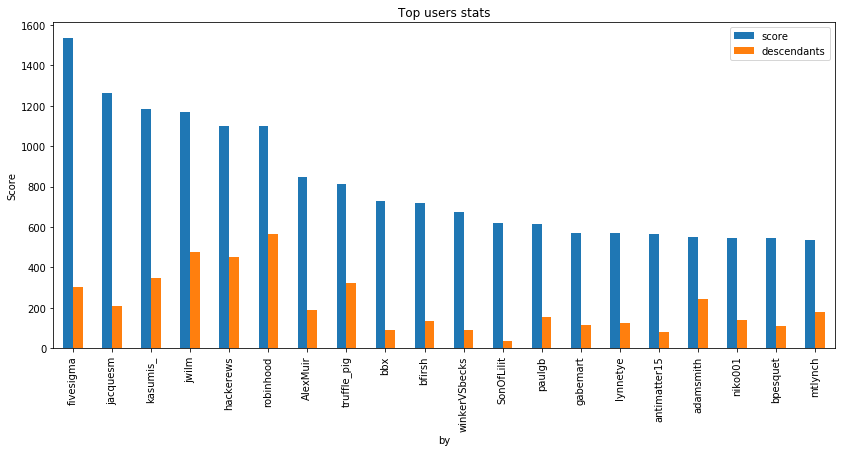

In [70]:
stories_2017.sort_values("score")[::-1][:20].plot(x="by",y=["score", "descendants"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Score")

Text(0, 0.5, 'Score')

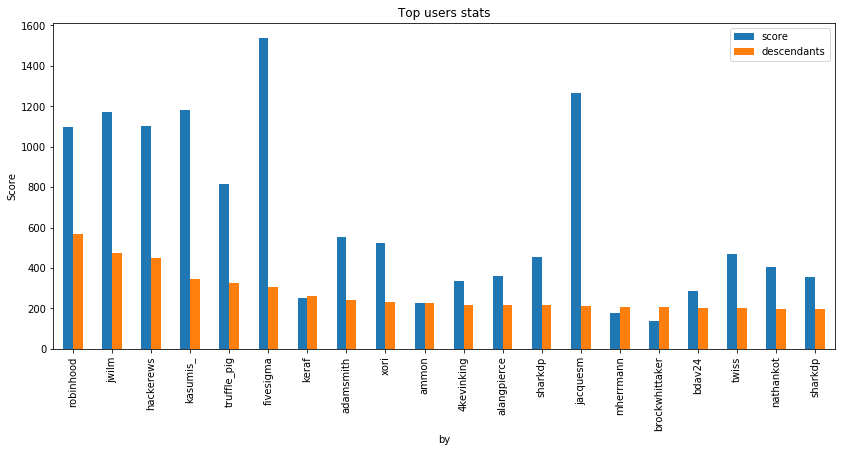

In [69]:
stories_2017.sort_values("descendants")[::-1][:20].plot(x="by",y=["score", "descendants"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Score")